In [1]:
import numpy as np
import pandas as pd
import csv
import os

In [2]:
import nltk
import string, unicodedata
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer
import re

In [3]:
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble
from sklearn.datasets import load_files
from keras import layers, models, optimizers
sw = stopwords.words('english')
np.array(sw)
from tensorflow.keras.utils import plot_model

In [4]:
# Path_to_CSV_will_be_different_in_each_case
train_data = pd.read_csv('train.csv',names=["class index","title","description"])

In [5]:
def remove_punctuation(text):
    import string
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)

def stopwords_removal(text):
    text = [word.lower() for word in text.split() if word.lower() not in sw]
    return " ".join(text)



In [6]:
train_data['description'] = train_data['description'].apply(remove_punctuation)
train_data['title'] = train_data['title'].apply(remove_punctuation)
train_data['description'] = train_data['description'].apply(stopwords_removal)
train_data['title'] = train_data['title'].apply(stopwords_removal)
train_data.head(10)

,class index,title,description
0,3,wall st bears claw back black reuters,reuters shortsellers wall streets dwindlingban...
1,3,carlyle looks toward commercial aerospace reuters,reuters private investment firm carlyle groupw...
2,3,oil economy cloud stocks outlook reuters,reuters soaring crude prices plus worriesabout...
3,3,iraq halts oil exports main southern pipeline ...,reuters authorities halted oil exportflows mai...
4,3,oil prices soar alltime record posing new mena...,afp tearaway world oil prices toppling records...
5,3,stocks end near year lows reuters,reuters stocks ended slightly higher fridaybut...
6,3,money funds fell latest week ap,ap assets nations retail money market mutual f...
7,3,fed minutes show dissent inflation usatodaycom,usatodaycom retail sales bounced back bit july...
8,3,safety net forbescom,forbescom earning phd sociology danny bazil ri...
9,3,wall st bears claw back black,new york reuters shortsellers wall streets dwi...


In [7]:
def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas
train_data['title'].head(10)
train_data['description']=lemmatize_verbs(train_data['description'])
train_data['title']=lemmatize_verbs(train_data['title'])

In [8]:
def corpus_generation(data):
    sent_list=[sent for sent in data] 
    corpus=[]
    for sentence in sent_list:
        tokens=nltk.word_tokenize(sentence)
        corpus.append(tokens)
    return corpus


In [9]:
corpus=corpus_generation(train_data['description'])
corpus[1]

['reuters',
 'private',
 'investment',
 'firm',
 'carlyle',
 'groupwhich',
 'reputation',
 'making',
 'welltimed',
 'occasionallycontroversial',
 'plays',
 'defense',
 'industry',
 'quietly',
 'placedits',
 'bets',
 'another',
 'part',
 'market']

In [10]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix

In [11]:
def bag_of_words():
    print(len(train_data['description']))
    vectors=CountVectorizer(max_features=1000,min_df=3,max_df=0.6,stop_words='english')
    vect=vectors.fit_transform(train_data['description'])
    return vect

def tfidf_values():
    tfidf=TfidfTransformer()
    vect=bag_of_words()
    tfidf_converted=tfidf.fit_transform(vect).toarray()
    return tfidf_converted
tfidf_converted=tfidf_values()
tfidf_converted


120000


array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.14061904, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [12]:
tfidf_converted.shape

(120000, 1000)

In [13]:
def one_hot_encoding(y):
    y = pd.get_dummies(y, columns=['class index'], prefix = 'classes')
    print(np.shape(y))
    return y

y=one_hot_encoding(train_data['class index'])
y=np.array(y)
np.shape(y)

(120000, 4)


(120000, 4)

In [14]:
train_x,valid_x,train_y,valid_y=train_test_split(tfidf_converted,y)

In [15]:
def create_model_architecture(input_size):
    # create input layer 
    input_layer = layers.Input((input_size), sparse=True)
    
    # create hidden layer
    hidden_layer = layers.Dense(100, activation="relu")(input_layer)
    
    # create output layer
    output_layer = layers.Dense(4, activation="sigmoid")(hidden_layer)

    classifier = models.Model(inputs = input_layer, outputs = output_layer)
    classifier.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy')
    return classifier 


classifier = create_model_architecture(train_x.shape[1])
classifier.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1000)]            0         
_________________________________________________________________
dense (Dense)                (None, 100)               100100    
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 404       
Total params: 100,504
Trainable params: 100,504
Non-trainable params: 0
_________________________________________________________________


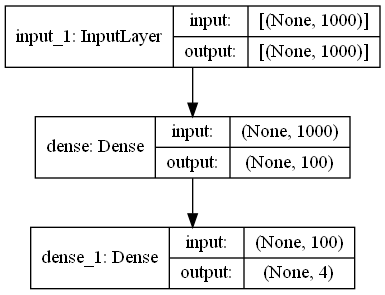

In [24]:
plot_model(classifier, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [16]:
# train_y.shape
classifier.fit(train_x, train_y,epochs=5)

Epoch 1/5
2813/2813 [==============================] - 4s 1ms/step - loss: 0.2968
Epoch 2/5
2813/2813 [==============================] - 3s 1ms/step - loss: 0.1791
Epoch 3/5
2813/2813 [==============================] - 3s 1ms/step - loss: 0.1706
Epoch 4/5
2813/2813 [==============================] - 3s 1ms/step - loss: 0.1642
Epoch 5/5
2813/2813 [==============================] - 3s 1ms/step - loss: 0.1593


In [17]:
y_pred=classifier.predict_step(valid_x)
y_pred

<tf.Tensor: shape=(30000, 4), dtype=float32, numpy=
array([[1.51356459e-01, 1.32697821e-03, 7.01236069e-01, 8.98960233e-02],
       [8.13572407e-01, 1.64300203e-04, 1.25388205e-02, 7.79733658e-02],
       [1.06997788e-02, 5.44779396e-05, 6.52999818e-01, 2.53291249e-01],
       ...,
       [7.95334578e-04, 1.29601267e-06, 6.78762197e-02, 9.31387126e-01],
       [8.49418044e-01, 2.96160579e-03, 4.30402756e-02, 1.05001956e-01],
       [9.23068285e-01, 2.80031545e-05, 1.32935345e-02, 3.39093208e-02]],
      dtype=float32)>

In [18]:
n_classes=train_data['class index'].nunique()
n_classes

4

In [19]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

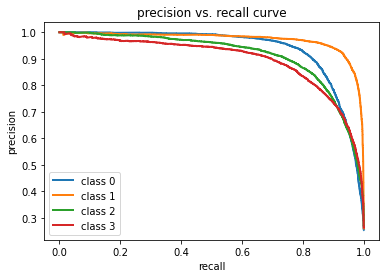

In [20]:
precision = dict()
recall = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(valid_y[:, i],
                                                        y_pred[:, i])
    plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i))
    
plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision vs. recall curve")
plt.show()